![](img/330-banner.png)

# Lecture 22: Ethics

UBC 2022-23

Instructor: Varada Kolhatkar

## Imports

In [1]:
import os
import sys

import IPython
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

from sklearn.metrics import ConfusionMatrixDisplay  # Recommended method in sklearn 1.0

%matplotlib inline
pd.set_option("display.max_colwidth", 200)

from IPython.display import Image

<br><br>

## Lecture plan 

- Guest lecture by [Giulia Toti](https://www.gtoti.com/) (~50 mins)
    - The slides will be made available soon. 
- ML fairness activity (~15 mins)

## ML fairness activity

AI/ML systems can give the illusion of objectivity as they are derived from seemingly unbiased data & algorithm. However, human are inherently biased and AI/ML systems, if not carefully evaluated, can even further amplify the existing inequities and systemic bias in our society.  

How do we make sure our AI/ML systems are *fair*? Which metrics can we use to quatify 'fairness' in AI/ML systems?

Let's examine this on [the adult census data set](https://www.kaggle.com/uciml/adult-census-income). 

In [2]:
census_df = pd.read_csv("data/adult.csv")
census_df.shape

(32561, 15)

In [3]:
train_df, test_df = train_test_split(census_df, test_size=0.4, random_state=42)

In [4]:
train_df

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
25823,36,Private,245521,7th-8th,4,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,35,Mexico,<=50K
10274,26,Private,134287,Assoc-voc,11,Never-married,Sales,Own-child,White,Female,0,0,35,United-States,<=50K
27652,25,Local-gov,109526,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,38,United-States,<=50K
13941,23,Private,131275,HS-grad,9,Never-married,Craft-repair,Own-child,Amer-Indian-Eskimo,Male,0,0,40,United-States,<=50K
31384,27,Private,193122,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,25,Private,410240,HS-grad,9,Never-married,Craft-repair,Own-child,White,Male,0,0,40,United-States,<=50K
5390,51,Private,146767,Assoc-voc,11,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,>50K
860,55,Federal-gov,238192,HS-grad,9,Married-civ-spouse,Tech-support,Husband,White,Male,0,1887,40,United-States,>50K
15795,41,Private,154076,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,50,United-States,>50K


In [5]:
train_df_nan = train_df.replace("?", np.nan)
test_df_nan = test_df.replace("?", np.nan)
train_df_nan.shape

(19536, 15)

In [6]:
# Let's identify numeric and categorical features

numeric_features = [
    "age",
    "capital.gain",
    "capital.loss",
    "hours.per.week",
]

categorical_features = [
    "workclass",
    "marital.status",
    "occupation",
    "relationship",
    "race",
    "native.country",
]

ordinal_features = ["education"]
binary_features = [
    "sex"
]  # Not binary in general but in this particular dataset it seems to have only two possible values
drop_features = ["education.num", "fnlwgt"]
target = "income"

In [7]:
train_df["education"].unique()

array(['7th-8th', 'Assoc-voc', 'HS-grad', 'Bachelors', 'Some-college',
       '10th', '11th', 'Prof-school', '12th', '5th-6th', 'Masters',
       'Assoc-acdm', '9th', 'Doctorate', '1st-4th', 'Preschool'],
      dtype=object)

In [8]:
education_levels = [
    "Preschool",
    "1st-4th",
    "5th-6th",
    "7th-8th",
    "9th",
    "10th",
    "11th",
    "12th",
    "HS-grad",
    "Prof-school",
    "Assoc-voc",
    "Assoc-acdm",
    "Some-college",
    "Bachelors",
    "Masters",
    "Doctorate",
]

In [9]:
assert set(education_levels) == set(train_df["education"].unique())

In [10]:
X_train = train_df_nan.drop(columns=[target])
y_train = train_df_nan[target]

X_test = test_df_nan.drop(columns=[target])
y_test = test_df_nan[target]

In [11]:
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

numeric_transformer = make_pipeline(StandardScaler())

ordinal_transformer = OrdinalEncoder(categories=[education_levels], dtype=int)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

binary_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(drop="if_binary", dtype=int),
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features),
)

In [12]:
y_train.value_counts()

<=50K    14841
>50K      4695
Name: income, dtype: int64

In [13]:
pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(class_weight="balanced", max_iter=1000)
)

In [14]:
pipe_lr.fit(X_train, y_train);

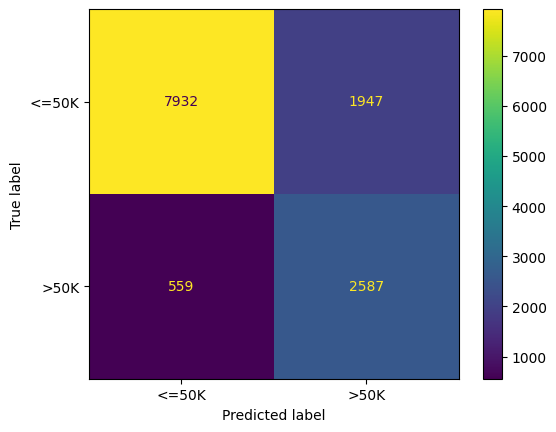

In [15]:
cm = ConfusionMatrixDisplay.from_estimator(pipe_lr, X_test, y_test);

Let's examine confusion matrix separately for the two genders we have in the data. 

In [16]:
X_train_enc = preprocessor.fit_transform(X_train)
preprocessor.named_transformers_["pipeline-2"]["onehotencoder"].get_feature_names_out()

array(['x0_Male'], dtype=object)

In [17]:
X_test.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
14160,29,Private,280618,Some-college,10,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States
27048,19,Private,439779,Some-college,10,Never-married,Sales,Own-child,White,Male,0,0,15,United-States
28868,28,Private,204734,Some-college,10,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,40,United-States
5667,35,Private,107991,11th,7,Never-married,Sales,Not-in-family,White,Male,0,0,45,United-States
7827,20,Private,54152,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,30,NaN


In [18]:
X_female = X_test.query("sex=='Female'")  # X where sex is female
X_male = X_test.query("sex=='Male'")  # X where sex is male

y_female = y_test[X_female.index]  # y where sex is female
y_male = y_test[X_male.index]  # y where sex is male

**Get predictions for `X_female` and `y_male` with `pipe_lr`**

In [19]:
female_preds = pipe_lr.predict(X_female)
male_preds = pipe_lr.predict(X_male)

Let's examine the accuracy and confusion matrix for female class.  

In [20]:
print(classification_report(y_female, female_preds))

              precision    recall  f1-score   support

       <=50K       0.96      0.94      0.95      3851
        >50K       0.57      0.66      0.61       463

    accuracy                           0.91      4314
   macro avg       0.76      0.80      0.78      4314
weighted avg       0.92      0.91      0.91      4314



<Figure size 600x400 with 0 Axes>

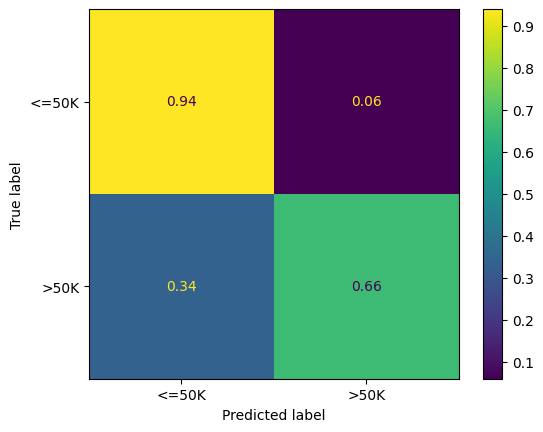

In [21]:
plt.figure(figsize=(6,4))
ConfusionMatrixDisplay.from_estimator(pipe_lr, X_female, y_female, normalize="true");

<br><br>

Let's examine the accuracy and confusion matrix for male class.  

In [22]:
print(classification_report(y_male, male_preds))

              precision    recall  f1-score   support

       <=50K       0.91      0.72      0.80      6028
        >50K       0.57      0.85      0.68      2683

    accuracy                           0.76      8711
   macro avg       0.74      0.78      0.74      8711
weighted avg       0.81      0.76      0.77      8711



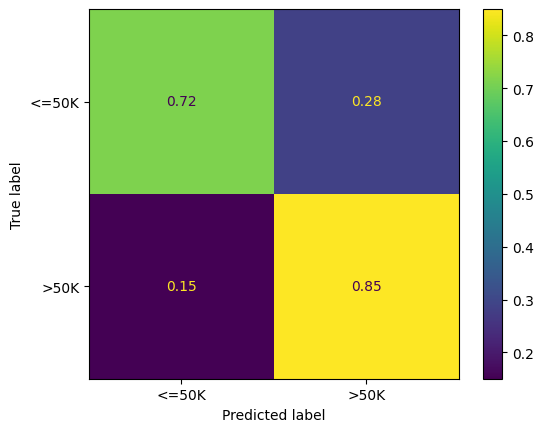

In [23]:
ConfusionMatrixDisplay.from_estimator(pipe_lr, X_male, y_male, normalize="true");

### ❓❓ Questions for group discussion

Let's assume that a company is using this classifier for loan approval with a simple rule that if the income is >=50K, approve the loan else reject the loan. 

In your group, discuss the questions below and write the main points from your discussion in this [Google document](https://docs.google.com/document/d/1hgkyxxvir-WddFhzuO6pRWjGnItEODbjFi-VUsIjYCk/edit#). 

1. Which group has a higher accuracy?
2. Which group has a higher precision for class >50K? What about recall for class >50K?
3. Will both groups have more or less the same proportion of people with approved loans? 
4. If a male and a female have both a certain level of income, will they have the same chance of getting the loan?
5. Banks want to avoid approving unqualified applications (false positives) because default loan could have detrimental effects for them. Compare the false positive rates for the two groups.    
6. Overall, do you think this income classifier will fairly treat both groups? What will be the consequences of using this classifier in loan approval application? 


**Time permitting**
1. Do you think the effect will still exist if the sex feature is removed from the model (but you still have it available separately to do the two confusion matrices)? 
2. Are there any other groups in this dataset worth examining for biases? 